In [44]:
import numpy as np
import h5py
import glob, os, re, sys

import pickle
import json
import numpy as np
import torch
from pathlib import Path
import matplotlib.pyplot as plt
from ETGDatasets import ETGDataset

from scipy.stats import binned_statistic
from scipy.stats import binned_statistic_2d

In [45]:
# Plotting properties
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from matplotlib import rc
from matplotlib.lines import Line2D
rc('font',**{'family':'DejaVu Sans','sans-serif':['Helvetica']})

grey = '#3C3C3C'
from matplotlib import rc
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['xtick.major.pad'] = 5
mpl.rcParams['ytick.major.pad'] = 5
mpl.rcParams['axes.labelpad'] = 10
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['xtick.color'] = grey
mpl.rcParams['ytick.color'] = grey
mpl.rcParams['axes.edgecolor'] = grey
mpl.rcParams['axes.labelcolor'] = grey
rc('axes', linewidth=1.5)
rc('axes', edgecolor=grey)
labels_font = {'size':'20'} 

In [46]:
# units
kpc_to_cm = 3.086e21
pc_to_cm = 3.086e18
kpc_to_pc = 1000.
kms_to_cms = 1.e5
Msol_to_g = 1.99e33
G_cgs = 6.67e-8
gamma = 5./3.
kB_cgs = 1.38e-16
mu = 1.4
mp_g = 1.67e-24
Myr_to_s = 3.154e13
yr_to_s = 3.154e7
Gyr_to_s = 3.154e16

In [47]:
def flatten_list(lst):
	if type(lst[0])==list:
		return [item for sublist in lst for item in sublist]
	else:
		return lst

In [48]:
def get_data(input_features, output_features, galaxy_types):
    etg = ETGDataset(
        input_features=input_features,
        output_features=output_features,
        galaxy_types=galaxy_types,
        input_resolution='LR',
        output_resolution='LR',
        # add a flag in this class for minimum mid-plane density?
        # add a flag for return as image or as flat list?
    )
    print(len(etg))
    inputs = [[] for i in range(len(input_features))]
    outputs = [[] for i in range(len(output_features))]
    for index in range(0,len(etg),10): # sampling every 10 snapshots
        input_features, output_features = etg[index]
        for i in range(len(input_features)):
            inputs[i].append(list(np.ravel(input_features[i])))
        for i in range(len(output_features)):
            outputs[i].append(list(np.ravel(output_features[i])))

    inputs_array_list = []
    for i in range(len(inputs)):
        inputs_array_list.append(np.array(flatten_list(inputs[i])))
    inputs_array = np.stack(inputs_array_list)
    inputs_array = np.swapaxes(inputs_array, 0, 1)

    outputs_array_list = []
    for i in range(len(outputs)):
        outputs_array_list.append(np.array(flatten_list(outputs[i])))
    outputs_array = np.stack(outputs_array_list)
    outputs_array = np.swapaxes(outputs_array, 0, 1)
    return inputs_array, outputs_array

In [84]:
def standarize_data(X, Y, log_X_idcs):
    print(np.shape(X), np.shape(Y), len(Y[:,0]), len(Y[:,0][Y[:,0]==0]))
    if(len(log_X_idcs)>0):
        cnd = (Y[:,0]>0) & (np.min(X[:,log_X_idcs], axis=1)>0) & (~np.isnan(np.min(X[:,log_X_idcs], axis=1)))
    else:
        cnd = (Y[:,0]>0)

    logY = np.zeros((len(Y[cnd,0]), 1))
    logY[:,0] = np.log10(Y[cnd,0])

    logX = np.zeros((len(logY), np.shape(X)[1]))
    for idx in range(np.shape(X)[1]):
        if idx in log_X_idcs:
            logX[:,idx] = np.log10(X[cnd,idx])
        else:
            logX[:,idx] = X[cnd,idx]

    print(np.shape(logX), np.shape(logY))
    norm_dict = {
        'x_min': np.min(logX, axis=0),
        'y_min': np.min(logY, axis=0),
    }

    norm_dict['x_mean'] =  np.mean(logX, axis=0)
    norm_dict['x_std'] =  np.std(logX, axis=0)

    norm_dict['y_mean'] =  np.mean(logY, axis=0)
    norm_dict['y_std'] =  np.std(logY, axis=0)

    logX = (logX - norm_dict['x_mean']) / norm_dict['x_std']
    logY = (logY - norm_dict['y_mean']) / norm_dict['y_std']
    return logX, logY, norm_dict

# load all the data to test

In [100]:
galaxies_to_test = ['ETG-vlowmass', 'ETG-lowmass', 'ETG-himass', 'NGC300', 'MW']
training_set = '0-nomedmass'

In [101]:
Xs, Ys, norm_dicts = [], [], []
for galaxy_to_test in galaxies_to_test:
    galaxy_types = sorted([galaxy_to_test])
    print(galaxy_to_test)

    # define sets of training features
    # features that are reliable in cosmo sims
    if(training_set=='a'):
        input_features = sorted(['gas_surfdens', 'stellar_surfdens'])
    elif(training_set=='b'):
        input_features = sorted(['gas_surfdens', 'stellar_surfdens', 'weights'])
    elif(training_set=='c'):
        input_features = sorted(['gas_surfdens', 'stellar_surfdens', 'weights', 'kappas'])
    # features that might be reliable in cosmo sims, but it's debatable
    elif(training_set=='d'):
        input_features = sorted(['gas_surfdens', 'stellar_surfdens', 'weights', 'kappa',
        'midplane-dens', 'midplane-stellar-dens'])
    elif(training_set=='e'):
        input_features = sorted(['gas_surfdens', 'stellar_surfdens', 'weights', 'kappa',
        'midplane-dens', 'midplane-stellar-dens', 'midplane-Pturb', 'midplane-Pth'])
    else:
        input_features = sorted(['gas_surfdens', 'stellar_surfdens', 'weights', 'kappa',
        'midplane-dens', 'midplane-stellar-dens', 'midplane-Pturb', 'midplane-Pth', 'midplane-veldispz', 'midplane-veldisp3D'])

    print(input_features)
    log_features = input_features.copy()
    log_features_idx = [input_features.index(feature) for feature in log_features if feature in input_features]
    
    X, Y = get_data(
        input_features=input_features,
        output_features=['SFR_surfdens'],
        galaxy_types=galaxy_types,
    )
    X, Y, norm_dict = standarize_data(X, Y, log_features_idx)

    X = torch.tensor(X, dtype=torch.float32)#.to(device)
    Y = torch.tensor(Y, dtype=torch.float32)#.to(device)
    print(np.shape(X), np.shape(Y))
    
    Xs.append(X)
    Ys.append(Y)
    norm_dicts.append(norm_dict)

ETG-vlowmass
['gas_surfdens', 'kappa', 'midplane-Pth', 'midplane-Pturb', 'midplane-dens', 'midplane-stellar-dens', 'midplane-veldisp3D', 'midplane-veldispz', 'stellar_surfdens', 'weights']
301
(77500, 10) (77500, 1) 77500 64969
(12531, 10) (12531, 1)
torch.Size([12531, 10]) torch.Size([12531, 1])
ETG-lowmass
['gas_surfdens', 'kappa', 'midplane-Pth', 'midplane-Pturb', 'midplane-dens', 'midplane-stellar-dens', 'midplane-veldisp3D', 'midplane-veldispz', 'stellar_surfdens', 'weights']
301
(77500, 10) (77500, 1) 77500 48713
(28787, 10) (28787, 1)
torch.Size([28787, 10]) torch.Size([28787, 1])
ETG-himass
['gas_surfdens', 'kappa', 'midplane-Pth', 'midplane-Pturb', 'midplane-dens', 'midplane-stellar-dens', 'midplane-veldisp3D', 'midplane-veldispz', 'stellar_surfdens', 'weights']
300
(75000, 10) (75000, 1) 75000 32163
(42837, 10) (42837, 1)
torch.Size([42837, 10]) torch.Size([42837, 1])
NGC300
['gas_surfdens', 'kappa', 'midplane-Pth', 'midplane-Pturb', 'midplane-dens', 'midplane-stellar-dens', 

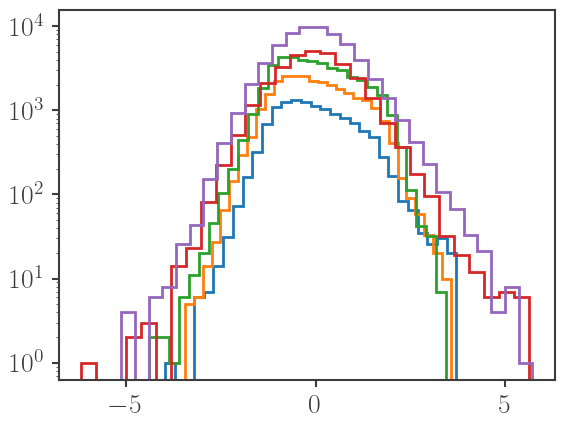

In [102]:
for X in Xs:
    plt.hist(np.array(X[:,0]), bins=30, log=True, histtype='step', lw=2)
plt.show()

# load the training data, trained on all galaxies *but* the galaxy to test

In [103]:
labels = [r"$\mathbf{M_*=10^{10}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{10.5}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{11}{\rm M}_\odot}$",
          r"$\mathbf{M_*=10^{11.5}{\rm M}_\odot}$",
          "NGC300",
          "Milky Way-like"]

/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/ETG-vlowmass/set_0-nomedmass
/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/ETG-vlowmass/set_0-nomedmass/flow_e28_0.5022.pkl
/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/ETG-lowmass/set_0-nomedmass
/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/ETG-lowmass/set_0-nomedmass/flow_e51_0.3646.pkl
/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/ETG-himass/set_0-nomedmass
/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/ETG-himass/set_0-nomedmass/flow_e48_0.5916.pkl
/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/NGC300/set_0-nomedmass
/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/NGC300/set_0-nomedmass/flow_e16_0.4797.pkl
/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/MW/set_0-nomedmass
/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/MW/set_0-nomedmass/flow_e11_0.0936.pkl


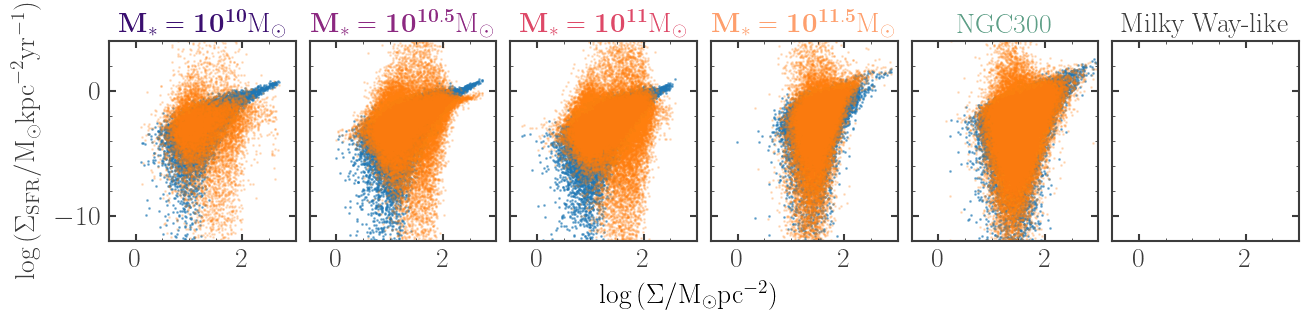

In [106]:
figW = 14
figH = 2.5
fig = plt.figure(figsize=(figW, figH))

botMarg = 0.1
topMarg = 0.1
leftMarg = 0.1
rightMarg = 0.1
wBetMarg = 0.01
hBetMarg = 0.02

crightMarg = 0.105
cW = 0.015
cBet = 0.002

h = (1.0-topMarg-botMarg)
w = (1.0-leftMarg-rightMarg)/6

### axes ###
ax0 = fig.add_axes([leftMarg, botMarg, w, h],
                   ylim=[-12., 4.], xlim=[-0.5, 3.],
                   ylabel=r'$\log{(\Sigma_{\rm SFR}/{\rm M}_\odot {\rm kpc}^{-2} {\rm yr}^{-1})}$')
ax1 = fig.add_axes([leftMarg+w+wBetMarg, botMarg, w, h],
                   ylim=[-12., 4.], xlim=[-0.5, 3.],
                   xlabel='', ylabel='', yticklabels='')
ax2 = fig.add_axes([leftMarg+2*(w+wBetMarg), botMarg, w, h],
                   ylim=[-12., 4.], xlim=[-0.5, 3.],
                   xlabel='', ylabel='', yticklabels='')
ax3 = fig.add_axes([leftMarg+3*(w+wBetMarg), botMarg, w, h],
                   ylim=[-12., 4.], xlim=[-0.5, 3.],
                   xlabel='', ylabel='', yticklabels='')
ax4 = fig.add_axes([leftMarg+4*(w+wBetMarg), botMarg, w, h],
                   ylim=[-12., 4.], xlim=[-0.5, 3.],
                   xlabel='', ylabel='', yticklabels='')
ax5 = fig.add_axes([leftMarg+5*(w+wBetMarg), botMarg, w, h],
                   ylim=[-12., 4.], xlim=[-0.5, 3.],
                   xlabel='', ylabel='', yticklabels='')

axs = [ax0, ax1, ax2, ax3, ax4, ax5]
for ax in axs:
    ax.tick_params(axis = 'both', bottom = True, top = True, left = True, right = True,
                   which = 'both', direction='in')
    ax.minorticks_on()

for ax, label, i in zip(axs, labels, range(len(axs))):
    if(i<4):
        color=plt.cm.magma(float(i+1)/5.)
    elif(i==4):
        color='#5E9F87'
    else:
        color='#3C3C3C'
    ax.set_title(label, color=color, fontsize=20)

fig.text(0.45, -0.15, r'$\log{(\Sigma/{\rm M}_\odot {\rm pc}^{-2})}$')

### plot/store stuff
gen_samples_unnorm = []
for galaxy, X, Y, norm_dict, ax in zip(galaxies_to_test, Xs, Ys, norm_dicts, axs):
    path_to_data = Path(
        "/n/holystore01/LABS/itc_lab/Lab/to-Carol/flows/"
    )

    all_galaxies = ['ETG-vlowmass', 'ETG-lowmass', 'ETG-medmass', 'ETG-himass', 'NGC300', 'MW']
    path_to_data = path_to_data / galaxy
    path_to_data = path_to_data / ("set_"+training_set)
    print(path_to_data)

    # find flow pkl
    flow_paths = sorted(list(path_to_data.glob('*.pkl')))
    sorted_strings = sorted(flow_paths, key=lambda s: float(s.name.rsplit('_')[2].rsplit('.pkl')[0]))
    print(sorted_strings[0])
    if(galaxy!='ETG-medmass'):
        with open(sorted_strings[0], 'rb') as f:
            flow = pickle.load(f)
    else:
        with open(sorted_strings[10], 'rb') as f:
            flow = pickle.load(f)

    # generate the samples and check the log prob
    gen_samples = flow.sample(1, context=X).detach().cpu().numpy()

    log_prob = flow.log_prob(
        inputs=Y, 
        context=X,
    )
    log_prob.mean()

    X_unnorm = X * norm_dict['x_std'] + norm_dict['x_mean']
    Y_unnorm = Y * norm_dict['y_std'] + norm_dict['y_mean']
    
    gen_samples_unnorm_ = gen_samples * norm_dict['y_std'] + norm_dict['y_mean']

    ax.scatter(
        X_unnorm[:,0],
        #X_unnorm[:,0],# - 1.e-12,
        Y_unnorm[:,0],# - 1.e-12,
        s=1, 
        label='True',
        alpha=0.5,
    )
    ax.scatter(
        #X_unnorm[:,0],# - 1.e-12,
        X_unnorm[:,0],
        gen_samples_unnorm_[:,0],# - 1.e-12,
        s=1, 
        alpha=0.2,
        label='Generated',
    )
    gen_samples_unnorm.append(gen_samples_unnorm_)

plt.show()

# save as medians and interquartile ranges

In [12]:
# folders = ['vlM-output', 'lowM-output', 'medM-output', 'hiM-output']
# minnos = [100,100,100,100]
# maxnos = [400,400,400,400]
# rsln = 80.*pc_to_cm

In [21]:
surfdens_min, SFRsurfdens_min = 0., -5.
surfdens_max, SFRsurfdens_max = 2.5, 1.
# surfdens_edges = np.linspace(surfdens_min, surfdens_max, 50)
# SFRsurfdens_edges = np.linspace(SFRsurfdens_min, SFRsurfdens_max, 50)
# surfdens_centres = (surfdens_edges[1:]+surfdens_edges[:-1])/2.
# SFRsurfdens_centres = (SFRsurfdens_edges[1:]+SFRsurfdens_edges[:-1])/2.

In [14]:
# # save as medians and interquartile ranges
# import warnings
# warnings.filterwarnings("ignore")

# logsurfdenses_MLdens_binedges = np.linspace(surfdens_min, surfdens_max, 30)
# logsurfdenses_MLdens_bincentres = (logsurfdenses_MLdens_binedges[1:]+logsurfdenses_MLdens_binedges[:-1])/2.

# med_logSigmaSFR_MLdenses, q1_logSigmaSFR_MLdenses, q4_logSigmaSFR_MLdenses, count_logSigmaSFR_MLdenses = [], [], [], []
# for X, norm_dict, gen_samples_unnorm_ in zip(Xs, norm_dicts, gen_samples_unnorm):
#     X_unnorm = np.array(X * norm_dict['x_std'] + norm_dict['x_mean'])
    
#     med_logSigmaSFR_MLdens, edges_rel, binno_rel = binned_statistic(
#         X_unnorm[:,1], gen_samples_unnorm_[:,0,0],
#         statistic=lambda x: np.nanmedian(x), bins=logsurfdenses_MLdens_binedges)
#     q1_logSigmaSFR_MLdens, edges_rel, binno_rel = binned_statistic(
#         X_unnorm[:,1], gen_samples_unnorm_[:,0,0],
#         statistic=lambda x: np.nanquantile(x, 0.25), bins=logsurfdenses_MLdens_binedges)
#     q4_logSigmaSFR_MLdens, edges_rel, binno_rel = binned_statistic(
#         X_unnorm[:,1], gen_samples_unnorm_[:,0,0],
#         statistic=lambda x: np.nanquantile(x, 0.75), bins=logsurfdenses_MLdens_binedges)
#     count_logSigmaSFR_MLdens, edges_rel, binno_rel = binned_statistic(
#         X_unnorm[:,1], gen_samples_unnorm_[:,0,0],
#         statistic='count', bins=logsurfdenses_MLdens_binedges)

#     med_logSigmaSFR_MLdenses.append(med_logSigmaSFR_MLdens)
#     q1_logSigmaSFR_MLdenses.append(q1_logSigmaSFR_MLdens)
#     q4_logSigmaSFR_MLdenses.append(q4_logSigmaSFR_MLdens)
#     count_logSigmaSFR_MLdenses.append(count_logSigmaSFR_MLdens)

In [15]:
# np.save("/n/holystore01/LABS/itc_lab/Users/sjeffreson/LtU-arrays/logsurfdenses_MLdensrots_bincentres.npy", logsurfdenses_MLdens_bincentres)
# for folder, med_logSigmaSFR_MLdenses_, q1_logSigmaSFR_MLdenses_, q4_logSigmaSFR_MLdenses_, count_logSigmaSFR_MLdenses_ in zip(
#     folders, med_logSigmaSFR_MLdenses, q1_logSigmaSFR_MLdenses, q4_logSigmaSFR_MLdenses, count_logSigmaSFR_MLdenses):
#     np.save("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/"+folder+"/LtU-arrays/med_logSigmaSFR_MLdensesrots.npy", med_logSigmaSFR_MLdenses_)
#     np.save("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/"+folder+"/LtU-arrays/q1_logSigmaSFR_MLdensesrots.npy", q1_logSigmaSFR_MLdenses_)
#     np.save("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/"+folder+"/LtU-arrays/q4_logSigmaSFR_MLdensesrots.npy", q4_logSigmaSFR_MLdenses_)
#     np.save("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/"+folder+"/LtU-arrays/count_logSigmaSFR_MLdensesrots.npy", count_logSigmaSFR_MLdenses_)

# load the 3D arrays for comparison to the normalizing flows prediction

In [32]:
# # load arrays
# surfdenses, SFRsurfdenses = [], []
# for folder, minno, maxno in zip(folders, minnos, maxnos):
#     arrs = sorted(glob.glob(os.path.join(
#         "/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/"+folder+"/LtU-arrays/SFR_voldens_cube_SH03_*.npy")))
#     arrnos = [arr.rsplit('SFR_voldens_cube_SH03_')[1].rsplit('.npy')[0] for arr in arrs]
    
#     surfdenses_, SFRsurfdenses_ = [], []
#     for no in arrnos:
#         voldens_cube = np.load(
#             "/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/"+folder+"/LtU-arrays/gas_voldens_cube_"+str(no)+".npy", allow_pickle=True)
#         SFRvoldens_cube = np.load(
#             "/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/"+folder+"/LtU-arrays/SFR_voldens_cube_"+str(no)+".npy", allow_pickle=True)
#         surfdens = np.sum(voldens_cube, axis=2) * rsln
#         SFRsurfdens = np.sum(SFRvoldens_cube, axis=2) * rsln
        
#         surfdenses_.append(list(np.ravel(surfdens)))
#         SFRsurfdenses_.append(list(np.ravel(SFRsurfdens)))
    
#     surfdenses.append(np.array(flatten_list(surfdenses_)))
#     SFRsurfdenses.append(np.array(flatten_list(SFRsurfdenses_)))

# show all four on one figure (with black background)

In [16]:
# # Plotting properties
# from matplotlib import rc
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['font.family'] = 'serif'
# mpl.rcParams['font.weight'] = 'normal'
# mpl.rcParams['xtick.major.pad'] = 5
# mpl.rcParams['ytick.major.pad'] = 5
# mpl.rcParams['axes.labelpad'] = 10
# mpl.rcParams['font.size'] = 20
# mpl.rcParams['legend.fontsize'] = 20
# mpl.rcParams['legend.numpoints'] = 1
# mpl.rcParams['savefig.dpi'] = 100
# mpl.rcParams['mathtext.default'] = 'regular'
# plt.rcParams['figure.facecolor'] = 'black'
# mpl.rcParams['text.color'] = 'white'
# mpl.rcParams['axes.labelcolor'] = 'white'
# mpl.rcParams['axes.facecolor'] = 'black'
# mpl.rcParams['axes.edgecolor'] = 'white'
# mpl.rcParams['xtick.color'] = 'white'
# mpl.rcParams['ytick.color'] = 'white'
# labels_font = {'size':'20'}

# cmap = plt.cm.pink
# cmap.set_bad('black')

In [17]:
# labels = [r"$\mathbf{M_*=10^{10}{\rm M}_\odot}$",
#           r"$\mathbf{M_*=10^{10.5}{\rm M}_\odot}$",
#           r"$\mathbf{M_*=10^{11}{\rm M}_\odot}$",
#           r"$\mathbf{M_*=10^{11.5}{\rm M}_\odot}$"]

In [18]:
# # load the SH03 approximation
# logsurfdenses_SH03_bincentres = np.load("/n/holystore01/LABS/itc_lab/Users/sjeffreson/LtU-arrays/logsurfdenses_SH03_bincentres.npy")

# med_logSigmaSFR_SH03s, q1_logSigmaSFR_SH03s, q4_logSigmaSFR_SH03s = [], [], []
# for folder in folders:
#     med_logSigmaSFR_SH03s.append(np.load("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/"+folder+"/LtU-arrays/med_logSigmaSFR_SH03.npy"))
#     q1_logSigmaSFR_SH03s.append(np.load("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/"+folder+"/LtU-arrays/q1_logSigmaSFR_SH03.npy"))
#     q4_logSigmaSFR_SH03s.append(np.load("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/"+folder+"/LtU-arrays/q4_logSigmaSFR_SH03.npy"))

In [19]:
# # load the PRFM approximation
# logsurfdenses_PRFM_bincentres = np.load("/n/holystore01/LABS/itc_lab/Users/sjeffreson/LtU-arrays/logsurfdenses_PRFM_bincentres.npy")

# med_logSigmaSFR_PRFMs, q1_logSigmaSFR_PRFMs, q4_logSigmaSFR_PRFMs = [], [], []
# for folder in folders:
#     med_logSigmaSFR_PRFMs.append(np.load("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/"+folder+"/LtU-arrays/med_logSigmaSFR_PRFM.npy"))
#     q1_logSigmaSFR_PRFMs.append(np.load("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/"+folder+"/LtU-arrays/q1_logSigmaSFR_PRFM.npy"))
#     q4_logSigmaSFR_PRFMs.append(np.load("/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/"+folder+"/LtU-arrays/q4_logSigmaSFR_PRFM.npy"))

NameError: name 'surfdenses' is not defined

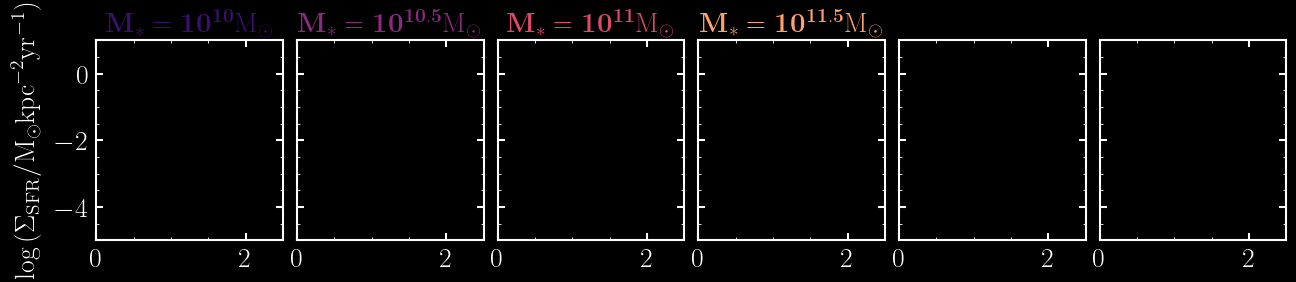

In [22]:
# figW = 14
# figH = 2.5
# fig = plt.figure(figsize=(figW, figH))

# botMarg = 0.1
# topMarg = 0.1
# leftMarg = 0.1
# rightMarg = 0.1
# wBetMarg = 0.01
# hBetMarg = 0.02

# crightMarg = 0.105
# cW = 0.015
# cBet = 0.002

# h = (1.0-topMarg-botMarg)
# w = (1.0-leftMarg-rightMarg)/6

# ### axes ###
# ax0 = fig.add_axes([leftMarg, botMarg+2.*(hBetMarg+h), w, h],
#                    ylim=[SFRsurfdens_min, SFRsurfdens_max], xlim=[surfdens_min, surfdens_max],
#                    ylabel=r'$\log{(\Sigma_{\rm SFR}/{\rm M}_\odot {\rm kpc}^{-2} {\rm yr}^{-1})}$')
# ax1 = fig.add_axes([leftMarg+w+wBetMarg, botMarg+2.*(hBetMarg+h), w, h],
#                    ylim=[SFRsurfdens_min, SFRsurfdens_max], xlim=[surfdens_min, surfdens_max],
#                    xlabel='', ylabel='', yticklabels='')
# ax2 = fig.add_axes([leftMarg+2*(w+wBetMarg), botMarg+2.*(hBetMarg+h), w, h],
#                    ylim=[SFRsurfdens_min, SFRsurfdens_max], xlim=[surfdens_min, surfdens_max],
#                    xlabel='', ylabel='', yticklabels='')
# ax3 = fig.add_axes([leftMarg+3*(w+wBetMarg), botMarg+2.*(hBetMarg+h), w, h],
#                    ylim=[SFRsurfdens_min, SFRsurfdens_max], xlim=[surfdens_min, surfdens_max],
#                    xlabel='', ylabel='', yticklabels='')
# ax4 = fig.add_axes([leftMarg+4*(w+wBetMarg), botMarg+2.*(hBetMarg+h), w, h],
#                    ylim=[SFRsurfdens_min, SFRsurfdens_max], xlim=[surfdens_min, surfdens_max],
#                    xlabel='', ylabel='', yticklabels='')
# ax5 = fig.add_axes([leftMarg+5*(w+wBetMarg), botMarg+2.*(hBetMarg+h), w, h],
#                    ylim=[SFRsurfdens_min, SFRsurfdens_max], xlim=[surfdens_min, surfdens_max],
#                    xlabel='', ylabel='', yticklabels='')

# axs = [ax0, ax1, ax2, ax3, ax4, ax5]
# for ax in axs:
#     ax.tick_params(axis = 'both', bottom = True, top = True, left = True, right = True,
#                    which = 'both', direction='in')
#     ax.minorticks_on()

# for ax, label, i in zip(axs, labels, range(len(axs))):
#     ax.set_title(label, color=plt.cm.magma(float(i+1)/5.), fontsize=20)

# ### plot stuff
# for i, X, Y, norm_dict, gen_samples_unnorm_ in zip(range(len(Xs)), Xs, Ys, norm_dicts, gen_samples_unnorm):
#     X_unnorm = np.array(X * norm_dict['x_std'] + norm_dict['x_mean'])
#     Y_unnorm = np.array(Y * norm_dict['y_std'] + norm_dict['y_mean'])
    
#     axs[i].hexbin(
#         np.log10(np.ravel(surfdenses[i]/Msol_to_g*pc_to_cm**2)),
#         np.log10(np.ravel(SFRsurfdenses[i])*yr_to_s*kpc_to_cm**2/Msol_to_g),
#         gridsize=30, bins='log',
#         vmin = 100., vmax = 5.e3,
#         extent=[np.min(surfdens_edges), np.max(surfdens_edges), np.min(SFRsurfdens_edges), np.max(SFRsurfdens_edges)],
#         cmap=plt.cm.bone, zorder=0
#     )
#     # counts, x_edge, y_edge, binnumber = binned_statistic_2d(
#     #     X_unnorm[:,1],
#     #     gen_samples_unnorm_[:,0,0],# - 1.e-12,
#     #     gen_samples_unnorm_[:,0,0],# - 1.e-12,
#     #     bins=(surfdens_edges, SFRsurfdens_edges),
#     #     statistic='count', expand_binnumbers='True'
#     # )
#     # maxcounts = np.max(counts)
#     # axs[i].contour(
#     #     surfdens_centres, SFRsurfdens_centres,
#     #     np.transpose(counts), levels=[maxcounts/5., 2*maxcounts/5., 3*maxcounts/5., 4*maxcounts/5.], cmap=plt.cm.Greens
#     # )

# for i in range(0,6):
#     X_unnorm = np.array(Xs[i] * norm_dicts[i]['x_std'] + norm_dicts[i]['x_mean'])
#     Y_unnorm = np.array(Ys[i] * norm_dicts[i]['y_std'] + norm_dicts[i]['y_mean'])
#     gen_samples_unnorm_ = gen_samples_unnorm[i]
#     counts, x_edge, y_edge, binnumber = binned_statistic_2d(
#         X_unnorm[:,1],
#         gen_samples_unnorm_[:,0,0],# - 1.e-12,
#         gen_samples_unnorm_[:,0,0],# - 1.e-12,
#         bins=(surfdens_edges, SFRsurfdens_edges),
#         statistic='count', expand_binnumbers='True'
#     )
#     maxcounts = np.max(counts)
#     axs[i].contour(
#         surfdens_centres, SFRsurfdens_centres,
#         np.transpose(counts), levels=[maxcounts/5., 2*maxcounts/5., 3*maxcounts/5., 4*maxcounts/5.], cmap=plt.cm.Greens
#     )

#     # cnd = (count_logSigmaSFR_MLdenses[i] > 100)
#     # axs[i].plot(logsurfdenses_MLdens_bincentres[cnd],
#     #             med_logSigmaSFR_MLdenses[i][cnd], color=plt.cm.magma(0.5), zorder=3)
#     # axs[i].fill_between(logsurfdenses_MLdens_bincentres[cnd],
#     #                     q4_logSigmaSFR_MLdenses[i][cnd], y2=q1_logSigmaSFR_MLdenses[i][cnd],
#     #                     alpha=0.5, color=plt.cm.magma(0.5), zorder=3)
    
#     # axs[i].plot(logsurfdenses_PRFM_bincentres[cnd], med_logSigmaSFR_PRFMs[i][cnd], color=plt.cm.magma(0.8), zorder=3)
#     # axs[i].fill_between(logsurfdenses_PRFM_bincentres[cnd], q4_logSigmaSFR_PRFMs[i][cnd], y2=q1_logSigmaSFR_PRFMs[i][cnd],
#     #                     alpha=0.5, color=plt.cm.magma(0.8), zorder=3)

#     # axs[i].plot(logsurfdenses_SH03_bincentres, med_logSigmaSFR_SH03s[i], color='white', zorder=2)
#     # axs[i].fill_between(logsurfdenses_SH03_bincentres, q1_logSigmaSFR_SH03s[i], y2=q4_logSigmaSFR_SH03s[i], alpha=0.5, color='white', zorder=2)

#     # axs[i].scatter(
#     #     #X_unnorm[:,0],# - 1.e-12,
#     #     X_unnorm[:,0],
#     #     gen_samples_unnorm_[:,0,0],# - 1.e-12,
#     #     s=1, 
#     #     alpha=0.2,
#     #     label='Generated', zorder=1
#     # )

# fig.text(0.5, 0.01, r'$\log{(\Sigma/{\rm M}_\odot {\rm pc}^{-2})}$')

# # plt.savefig(
# #     '/n/holystore01/LABS/itc_lab/Users/sjeffreson/ETGs/figs/test-flows-midplane-density-Omega-d.pdf',
# #     bbox_inches='tight',
# #     format='pdf'
# # )

# plt.show()